In [1]:
!nvidia-smi

Sun May  8 04:07:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
from tensorflow.python.keras.utils.data_utils import Sequence
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
dataset_path = '/content/drive/MyDrive/AI peralatan ayam/'


image_size = (640,640)
batch_size = 16


# Data generators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


train_batches = train_datagen.flow_from_directory(
        dataset_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='training')


validation_batches = train_datagen.flow_from_directory(
        dataset_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation')


test_batches = train_datagen.flow_from_directory(
        dataset_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary', 
        shuffle=False,
        subset='validation')

Found 1158 images belonging to 7 classes.
Found 288 images belonging to 7 classes.
Found 288 images belonging to 7 classes.


In [6]:
imgs, labels = next(train_batches)

In [7]:
def plotImages(images_arr):
    x = len(images_arr)
    fig, axes = plt.subplots(1, x, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

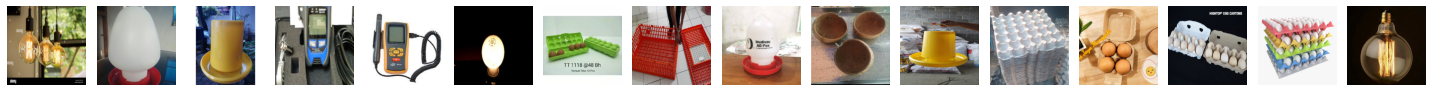

[2. 4. 4. 6. 6. 2. 0. 1. 5. 4. 4. 0. 0. 0. 0. 2.]


In [8]:
plotImages(imgs)
print(labels)

In [9]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(640,640,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Dropout(0.2),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Flatten(),
    Dropout(0.5),
    Dense(units=7, activation='softmax')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 640, 640, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 320, 320, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 320, 320, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 160, 160, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 160, 160, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 80, 80, 128)      0

In [11]:
model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
from keras.callbacks import ModelCheckpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [13]:
model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=validation_batches,
    validation_steps=len(validation_batches),
    epochs=200,
    verbose=1,
    callbacks=callbacks_list
)

Epoch 1/200
73/73 [==============================] - ETA: 0s - loss: 1.5634 - accuracy: 0.4491
Epoch 1: val_accuracy improved from -inf to 0.43403, saving model to weights.best.hdf5
73/73 [==============================] - 350s 5s/step - loss: 1.5634 - accuracy: 0.4491 - val_loss: 1.4601 - val_accuracy: 0.4340
Epoch 2/200
73/73 [==============================] - ETA: 0s - loss: 1.0980 - accuracy: 0.6002
Epoch 2: val_accuracy improved from 0.43403 to 0.48264, saving model to weights.best.hdf5
73/73 [==============================] - 24s 320ms/step - loss: 1.0980 - accuracy: 0.6002 - val_loss: 1.5986 - val_accuracy: 0.4826
Epoch 3/200
73/73 [==============================] - ETA: 0s - loss: 0.8471 - accuracy: 0.7228
Epoch 3: val_accuracy improved from 0.48264 to 0.56597, saving model to weights.best.hdf5
73/73 [==============================] - 23s 315ms/step - loss: 0.8471 - accuracy: 0.7228 - val_loss: 1.5325 - val_accuracy: 0.5660
Epoch 4/200
73/73 [==============================] - E

In [14]:
cp /content/weights.best.hdf5 /content/drive/MyDrive/CNN

cp: cannot overwrite directory '/content/drive/MyDrive/CNN/weights.best.hdf5' with non-directory


In [15]:
test_imgs, test_labels = next(test_batches)

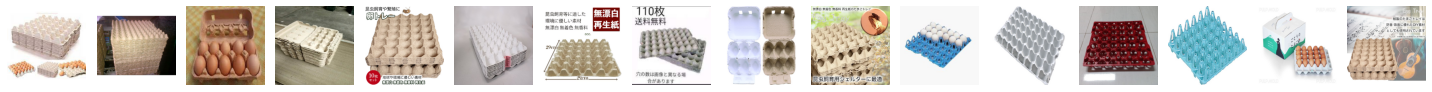

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [16]:
plotImages(test_imgs)
print(test_labels)

In [17]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=1)

18/18 [==============================] - 4s 199ms/step


In [18]:
print(model.evaluate(x=test_batches))

18/18 [==============================] - 4s 198ms/step - loss: 3.4541 - accuracy: 0.5174
[3.4540998935699463, 0.5173611044883728]


In [19]:
np.argmax(predictions, axis=-1)

array([4, 3, 6, 4, 3, 5, 4, 4, 4, 4, 6, 4, 0, 2, 2, 0, 0, 2, 5, 0, 0, 0,
       4, 2, 3, 3, 0, 0, 0, 2, 4, 4, 0, 0, 2, 0, 2, 0, 0, 0, 2, 6, 6, 0,
       1, 0, 2, 2, 2, 0, 4, 4, 5, 1, 1, 0, 1, 4, 4, 2, 1, 1, 1, 2, 6, 0,
       2, 4, 2, 0, 4, 2, 4, 2, 2, 6, 2, 2, 6, 1, 2, 3, 0, 3, 0, 0, 2, 2,
       0, 2, 3, 2, 0, 6, 2, 6, 2, 0, 0, 2, 0, 2, 2, 2, 4, 2, 2, 0, 2, 0,
       0, 2, 6, 6, 0, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 5, 4, 4, 4, 5, 5, 5, 5, 5, 1, 4, 4, 5, 4, 4, 4,
       4, 4, 4, 4, 0, 4, 5, 2, 4, 0, 5, 0, 0, 0, 0, 0, 4, 4, 0, 4, 4, 6,
       6, 0, 6, 4, 0, 4, 6, 4, 4, 4, 4, 5, 5, 5, 0, 5, 5, 0, 0, 5, 5, 5,
       0, 0, 5, 2, 5, 1, 4, 0, 5, 5, 0, 5, 0, 5, 5, 4, 4, 0, 5, 0, 5, 5,
       5, 5, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 0, 5, 6, 6, 6, 6,
       4, 0, 3, 0, 5, 3, 6, 6, 6, 0, 6, 4, 6, 6, 4, 6, 2, 6, 6, 6, 6, 4,
       6, 6, 4, 4, 0, 0, 6, 5, 6, 0, 0, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6,
       6, 6])

In [20]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    #normalize=True
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
test_batches.class_indices

{'Baki-wadah telur (250)': 0,
 'Keranjang ayam': 1,
 'Lampu (250)': 2,
 'Sarang Ayam-Tempat Bertelur': 3,
 'Tempat makan (250)': 4,
 'Tempat minum': 5,
 'Termometer (250)': 6}

Confusion matrix, without normalization
[[18  1 11  4 10  2  4]
 [ 1  6  2  0  4  1  1]
 [14  1 22  3  4  0  6]
 [ 0  0  0 21  1  2  0]
 [10  1  1  0 24 10  4]
 [12  1  1  0  4 31  0]
 [ 7  0  1  2 11  2 27]]


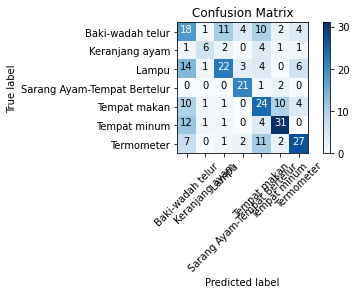

In [23]:
cm_plot_labels = ['Baki-wadah telur','Keranjang ayam', 'Lampu', 'Sarang Ayam-Tempat Bertelur', 'Tempat makan',  'Tempat minum', 'Termometer']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')